# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here


import torch
import torchvision
import json
import numpy as np
from torch import nn, optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.utils.data 
import pandas as pd

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt


/opt/anaconda3/envs/packages_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
training_dt = transforms.Compose( [
                        transforms.RandomRotation(30),
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
] )

validation_dt = transforms.Compose( [
                        transforms.Resize(255),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

testing_dt = transforms.Compose( [
                        transforms.Resize(255),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

# TODO: Load the three datasets with ImageFolder
training_ds = ImageFolder( train_dir, transform = training_dt )
validation_ds = ImageFolder( valid_dir, transform = validation_dt )
testing_ds = ImageFolder( test_dir, transform = testing_dt )

# TODO: Using the image datasets and the transforms, define the three associated dataloaders
dataLoaders = {

    'training' : torch.utils.data.DataLoader( training_ds, batch_size = 64, shuffle = True ),
    'validation' : torch.utils.data.DataLoader( validation_ds, batch_size = 64, shuffle = True ),
    'testing' : torch.utils.data.DataLoader( testing_ds, batch_size = 64, shuffle = True )

}

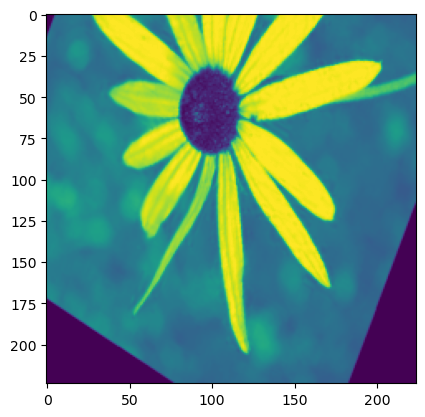

In [4]:
# view sample image
input, labels = next(iter(dataLoaders["training"]))
#print(len(input[0, 2]))

plt.imshow(input[0, 0])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network

# method to set the specific model and to retrieve model
#def get_model():

 #   model = models.vgg13( weights = 'VGG13_Weights.DEFAULT' )
  #  return model

In [7]:
def model_setup( hidden, class_to_idx, lr ):

    model = models.vgg13( weights = 'VGG13_Weights.DEFAULT' )
    
    # Freeze model parameters and update the classifier
    for param in model.parameters():
        param.requires_grad = False
    
    input_features = model.classifier[0].in_features
    #print("Input Size: ", input_size)
    output_size = 102 # number of classes of flowers

    classifier = nn.Sequential(OrderedDict([
                    ('fc0', nn.Linear(input_features, 4096)),
                    ('relu', nn.ReLU()),
                    ('dropout', nn.Dropout(p = 0.4)),
                    ('fc1', nn.Linear(4096, hidden)),
                    ('relu', nn.ReLU()),
                    ('dropout', nn.Dropout(p = 0.4)),
                    ('fc2', nn.Linear(hidden, output_size)),
                    ('output', nn.LogSoftmax(dim = 1))
    ]))

    model.classifier = classifier
    model.class_to_idx = class_to_idx
    #model = model.to('cpu')

    criterion = nn.NLLLoss()
    optimizer = optim.Adam( model.classifier.parameters(), lr )

    return model, criterion, optimizer

In [8]:
# build the model with the given data parameters
hidden_layers = 512  
class_to_idx = training_ds.class_to_idx
lr = 0.001

model, criterion, optimizer = model_setup( hidden_layers, class_to_idx, lr )

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [10]:
# define the training model as a method for code organization and efficiency
def model_train( model, num_epochs, criterion, optimizer, dataloaders_training, dataloaders_validation ):

    print("Data training process now underway...")
    
    steps = 0
    print_every = 10
   
    device = 'cpu'
    
    # use cuda if enabled
    if torch.cuda.is_available():
        device = 'cuda'

    for e in range(num_epochs):

        running_loss = 0

        for images, labels in iter(dataloaders_training):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #running_loss += loss.data

            training_loss = running_loss / print_every

            steps += 1

            # Run validation on the model and calculate loss and accuracy
            if steps % print_every == 0:               

                test_loss, accuracy = model_validate( model, criterion, dataloaders_validation )

                # Results output
                print("Epoch: {} / {} ".format( e+1, num_epochs ),
                      "Training Loss: {:.4f} ".format(training_loss),
                      "Validation Loss: {:.4f} ".format(test_loss),
                      "Accuracy: {:.4f} ".format(accuracy)                      
                      )
                
                running_loss = 0
                model.train()

In [11]:
# define the data validation as a method for code organization and efficiency
def model_validate( model, criterion, dataLoader ):
    
    test_loss = 0
    accuracy = 0

    model.eval()

    with torch.no_grad():        

        for inputs, labels in dataLoader:

            if torch.cuda.is_available():
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
            else:
                inputs, labels = inputs.to('cpu'), labels.to('cpu')
            #inputs, labels = inputs.to(device), labels.to(device)

            output = model.forward(inputs)
            #test_loss += criterion(output, labels).data
            test_loss += criterion(output, labels).item()

            #ps = torch.exp(output).data
            ps = torch.exp(output)
            #print((labels.data == ps.max(1)[1]))
            top_prob, top_class = ps.topk(1, dim = 1)
            equals = top_class == (labels.view(*top_class.shape))
            #equals = (labels.data == ps.max(1)[1])
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    valid_loss, valid_acc = test_loss / len(dataLoader), accuracy / len(dataLoader)

    return valid_loss, valid_acc

In [12]:
# Set the constants and loss and optimizer models and execute the training and validation
#learning = 0.001

epochs = 5 # set the number of cycles to train through
model_train( model, epochs, criterion, optimizer, dataLoaders['training'], dataLoaders['validation'] )

Data training process now underway...
Epoch: 1 / 5  Training Loss: 9.2533  Validation Loss: 5.7769  Accuracy: 0.0848 
Epoch: 1 / 5  Training Loss: 4.5518  Validation Loss: 3.6104  Accuracy: 0.2480 
Epoch: 1 / 5  Training Loss: 3.6462  Validation Loss: 2.8332  Accuracy: 0.3706 
Epoch: 1 / 5  Training Loss: 3.1931  Validation Loss: 2.3295  Accuracy: 0.4068 
Epoch: 1 / 5  Training Loss: 2.8527  Validation Loss: 1.8750  Accuracy: 0.5287 
Epoch: 1 / 5  Training Loss: 2.4644  Validation Loss: 1.7301  Accuracy: 0.5470 
Epoch: 1 / 5  Training Loss: 2.3192  Validation Loss: 1.4742  Accuracy: 0.5894 
Epoch: 1 / 5  Training Loss: 2.2739  Validation Loss: 1.4488  Accuracy: 0.6099 
Epoch: 1 / 5  Training Loss: 2.0422  Validation Loss: 1.3166  Accuracy: 0.6435 
Epoch: 1 / 5  Training Loss: 2.0255  Validation Loss: 1.1036  Accuracy: 0.7015 
Epoch: 2 / 5  Training Loss: 1.2954  Validation Loss: 1.0550  Accuracy: 0.7132 
Epoch: 2 / 5  Training Loss: 1.7047  Validation Loss: 1.0999  Accuracy: 0.7027 
Ep

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Do validation on the test set

correct = 0
total = 0
with torch.no_grad():        
    model.eval()
    for inputs, labels in dataLoaders['validation']:

        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
        else:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')

        output = model(inputs)
        _, predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('The test data accuracy is: %d%%' % (100 * (correct / total)))

The test data accuracy is: 85%


In [14]:
# TODO: Do validation on the test set
#test_data_loss, test_data_accuracy = validate_model( model, criterion, dataLoaders['testing'] )

#print("Testing Data Loss: {:.4f}".format(test_data_loss))
#print("Testing Data Accuracy: {:.4f}".format(test_data_accuracy))


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# TODO: Save the checkpoint
# create dictionary for model (note: classifier and arch attributes are not needed as build_model function will be utilized when executing checkpoint load/rebuild)

checkpoint = {    
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'classifier': model.classifier,
    'architecture': 'vgg13',
    'hidden_layers': hidden_layers,
    'learning_rate': lr,
    'epochs': epochs,
    'optimizer_state': optimizer.state_dict(),
    'input_features': model.classifier[0].in_features,
    'output_size': 102
}

torch.save(checkpoint, 'ic_checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:

# TODO: Write a function that loads a checkpoint and rebuilds the model
#def load_checkpoint(path):
#
#    checkpoint = torch.load('ic_checkpoint.pth')
#    
#    hl = checkpoint['hidden_layers']
#    class_to_idx = checkpoint['class_to_idx']
#    lr = checkpoint['learning_rate']
#    
#    model,_,_ = model_setup( hl, class_to_idx, lr )
#
#    model.load_state_dict(checkpoint['state_dict'])
#    optimizer.load_state_dict(checkpoint['optimizer'])
#    #optimizer.load_state_dict(checkpoint['optimizer'])    
    #model.class_to_idx = checkpoint['class_to_idx']    
    #model.load_state_dict(checkpoint['state_dict'])

#    return model, optimizer

In [15]:
"""
    Load a checkpoint and rebuild the model
    
    Args:
        filepath (str): Path to the checkpoint file
        load_optimizer (bool): If True, also rebuild and return the optimizer
        
    Returns:
        model: Rebuilt PyTorch model with loaded weights
        optimizer (optional): Optimizer with restored state (if load_optimizer=True)
        epochs (optional): Number of epochs already trained (if load_optimizer=True)
    """
def load_checkpoint(filepath, load_optimizer=False):
    
    # Load the checkpoint
    checkpoint = torch.load(filepath, map_location='cpu')  # Load to CPU first for compatibility

    # Freeze the feature parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Rebuild the classifier
    input_features = checkpoint['input_features']
    hidden_layers = checkpoint['hidden_layers']
    output_size = checkpoint['output_size']

    classifier = nn.Sequential(OrderedDict([
                    ('fc0', nn.Linear(input_features, 4096)),
                    ('relu', nn.ReLU()),
                    ('dropout', nn.Dropout(p=0.4)),
                    ('fc1', nn.Linear(4096, hidden_layers)),
                    ('relu', nn.ReLU()),
                    ('dropout', nn.Dropout(p=0.4)),
                    ('fc2', nn.Linear(hidden_layers, output_size)),
                    ('output', nn.LogSoftmax(dim=1))
    ]))

    # Attach the classifier to the model
    model.classifier = classifier
    
    # Load the trained weights
    model.load_state_dict(checkpoint['state_dict'])

    # Restore the class_to_idx mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # show output of retrieved model parameters
    print(f"Model loaded successfully")
    print(f"Architecture: {checkpoint['architecture']}")
    print(f"Hidden layers: {checkpoint['hidden_layers']}")
    print(f"Trained epochs: {checkpoint['epochs']}")
    print(f"Learning rate used: {checkpoint['learning_rate']}")

    # include optimizer for further training
    if load_optimizer:
        optimizer = optim.Adam(model.classifier.parameters(), lr=checkpoint['learning_rate'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        return model, optimizer, checkpoint['epochs']

    return model

In [17]:
# run checkpoint loading function and check results
model, optimizer, trained_epochs = load_checkpoint('ic_checkpoint.pth', load_optimizer=True)

print(model)

Model loaded successfully
Architecture: vgg13
Hidden layers: 512
Trained epochs: 5
Learning rate used: 0.001
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [25]:
"""
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns a Numpy array
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        np_image (numpy array): Processed image as numpy array ready for PyTorch
    """
def process_image(image_path):
        
    # Load the image
    pil_image = Image.open(image_path)
    
    # Get original dimensions
    width, height = pil_image.size
    
    # Resize where shortest side is 256 pixels, keeping aspect ratio
    if width <= height:
        # Width is shorter, so resize based on width
        new_width = 256
        new_height = int(256 * (height / width))
    else:
        # Height is shorter, so resize based on height  
        new_height = 256
        new_width = int(256 * (width / height))
    
    pil_image = pil_image.resize((new_width, new_height))
    
    # Crop out the center 224x224 portion
    width, height = pil_image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = left + 224
    bottom = top + 224
    
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # Convert PIL image to numpy array
    np_image = np.array(pil_image)
    
    # Convert from integers 0-255 to floats 0-1
    np_image = np_image / 255.0
    
    # Normalize using ImageNet means and standard deviations
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image - means) / stds
    
    # Reorder dimensions: PyTorch expects color channel first
    # Original: (height, width, channels) -> Target: (channels, height, width)
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [26]:
# Test function to verify image preprocessing works correctly
def test_process_image():
    
    # Test with your sample image
    processed_img = process_image(test_dir + '/10/image_07104.jpg')
    
    print("Processed image shape:", processed_img.shape)
    print("Expected shape: (3, 224, 224)")
    print("Image dtype:", processed_img.dtype)
    print("Min value:", processed_img.min())
    print("Max value:", processed_img.max())
    
    # Convert to tensor for model input
    image_tensor = torch.from_numpy(processed_img).float()
    print("Tensor shape:", image_tensor.shape)
    
    return processed_img

In [27]:
# run the test process on the image
processed_image = test_process_image()

Processed image shape: (3, 224, 224)
Expected shape: (3, 224, 224)
Image dtype: float64
Min value: -2.1179039301310043
Max value: 2.6399999999999997
Tensor shape: torch.Size([3, 224, 224])


In [28]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

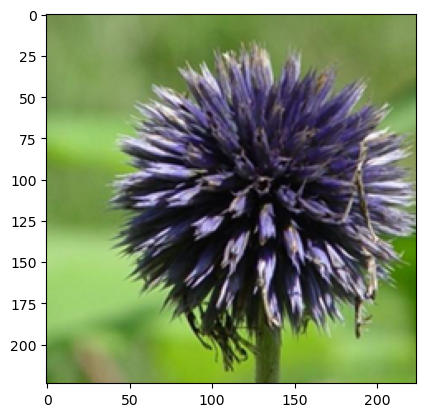

In [31]:
# Test processed image
processed_tensor = torch.from_numpy(processed_image).float()
imshow(processed_tensor, title="Processed Tensor")
plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [32]:
def predict(image_path, model, topk=5):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
        image_path (str): Path to image file
        model: Trained PyTorch model
        topk (int): Return top k most likely classes
        
    Returns:
        probs (list): Top k probabilities
        classes (list): Top k class labels
    """
    
    # Determine device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Process the image (returns numpy array)
    processed_image = process_image(image_path)  # Pass file path, not PIL image
    
    # Convert numpy array to tensor and add batch dimension
    image_tensor = torch.from_numpy(processed_image).float()
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension: (1, 3, 224, 224)
    
    # Move to device
    image_tensor = image_tensor.to(device)
    model = model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        
    # Calculate probabilities using softmax (since model outputs log probabilities)
    ps = torch.exp(output)
    
    # Get top k probabilities and indices
    top_probs, top_indices = ps.topk(topk, dim=1)
    
    # Move tensors back to CPU before converting to numpy
    top_probs = top_probs.cpu()
    top_indices = top_indices.cpu()
    
    # Convert to lists
    probs = top_probs.numpy().squeeze().tolist()  # Remove batch dimension and convert
    indices = top_indices.numpy().squeeze().tolist()
    
    # Handle case where topk=1 (single values, not lists)
    if topk == 1:
        probs = [probs]
        indices = [indices]
    
    # Convert indices to class labels
    # Invert the class_to_idx dictionary
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices]
    
    return probs, classes

In [33]:
# Test the function
def test_predict():
        
    image_path = test_dir + '/10/image_07104.jpg'
    
    print("Making prediction...")
    probs, classes = predict(image_path, model, topk=5)
    
    print("Top 5 predictions:")
    print(f"Probabilities: {probs}")
    print(f"Classes: {classes}")
    
    # Show class names if available
    if 'cat_to_name' in globals():
        print("\nClass names:")
        for i, class_idx in enumerate(classes):
            class_name = cat_to_name.get(class_idx, 'Unknown')
            print(f"{i+1}. {class_name}: {probs[i]:.4f}")
    
    return probs, classes

# execute the test
probs, classes = test_predict()

Making prediction...
Top 5 predictions:
Probabilities: [0.9992666840553284, 0.0007261280552484095, 5.127472377353115e-06, 1.6948259826676804e-06, 3.9643333593630814e-07]
Classes: ['10', '14', '38', '92', '22']

Class names:
1. globe thistle: 0.9993
2. spear thistle: 0.0007
3. great masterwort: 0.0000
4. bee balm: 0.0000
5. pincushion flower: 0.0000


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [34]:
def classify_image(img_path, cls, probs, c_t_n):
    """
    Display an image along with the top 5 classes
        
    Args:
        img_path (str): Path to image file
        cls (list): List of class indices
        probs (list): List of probabilities
        c_t_n (dict): cat_to_name dictionary
    """
    
    max_index = np.argmax(probs)
    max_probs = probs[max_index]
    label = cls[max_index]
    
    # Process image - fix: pass image path, not PIL image
    processed_image = process_image(img_path)  # This returns numpy array
    
    # Convert numpy array to tensor, then permute dimensions
    image_tensor = torch.from_numpy(processed_image).float()
    new_image = image_tensor.permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
    
    # Undo normalization for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    new_image = new_image * std + mean
    new_image = torch.clamp(new_image, 0, 1)  # Clip values to [0,1]
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot2grid((15, 9), (0, 0), colspan=9, rowspan=9)
    ax2 = plt.subplot2grid((15, 9), (9, 2), colspan=5, rowspan=5)

    ax1.axis('off')
    ax1.set_title(c_t_n[label])    
    ax1.imshow(new_image)

    labels = []
    for cl in cls:
        labels.append(c_t_n[cl])

    y_pos = np.arange(len(cls))  # Use len(cls) instead of hardcoded 5
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')
    ax2.barh(y_pos, probs, xerr=0, align='center', color='steelblue')

    plt.show()

Using your classify_image function directly:


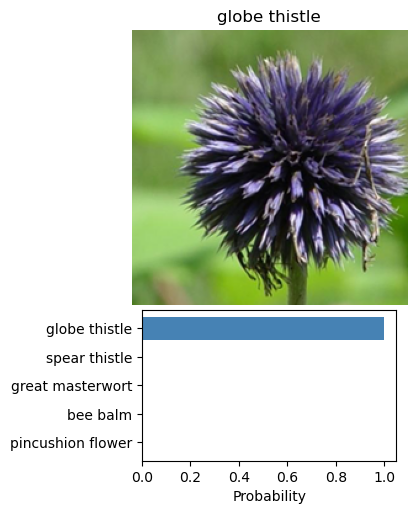

In [35]:
def test_classify_image():
        
    image_path = test_dir + '/10/image_07104.jpg'
    
    # Make predictions
    probs, classes = predict(image_path, model, topk=5)
    
    # Use your function directly
    print("Using your classify_image function directly:")
    classify_image(image_path, classes, probs, cat_to_name)

# execute the classify_image feature
test_classify_image()